<a href="https://colab.research.google.com/github/maximmillion/ConvCancer/blob/main/GLCM_synthetic_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import History 

from random import randint
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import cv2

from skimage.filters import gaussian
from skimage.util import random_noise
import matplotlib.pyplot as pp

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

from tensorflow.keras import datasets, layers, models
from xgboost import XGBClassifier
%matplotlib inline

# Making the dataset:

In [6]:
import os
from tqdm import tqdm
from skimage.io import imread

# read all the images first
x_train = []
for i in range(1, 4): # changed to 3 classes
    base_dir = f'/content/drive/MyDrive/cancer_dataG/stage_{i}_png/'
    files = os.listdir(base_dir)
    for file in tqdm(files):
        img = imread(base_dir+file)
        x_train.append(img)
X_train = np.array(x_train)
X_train.shape

100%|██████████| 250/250 [02:57<00:00,  1.41it/s]


(750, 512, 512)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [8]:
NUM = 250
CLASSES = 3 #4
y_train = []
class_label = 0
for i in range(NUM * CLASSES):
    if i > 0 and i %  NUM == 0:
        class_label += 1
    y_train.append(class_label)
Y_train = np.array(y_train)

In [9]:
# Shuffle training data
shuffler = np.random.permutation(NUM * CLASSES)

X_train = np.array(X_train)

x_train = X_train[shuffler].astype(np.uint8)
y_train = Y_train[shuffler]

2


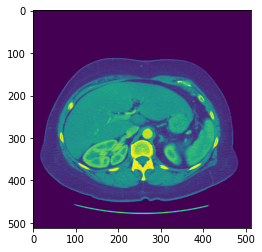

In [10]:
print(y_train[101])
plt.imshow(x_train[101])

# GLCM Feature extraction:

In [11]:
from skimage.feature import greycomatrix, greycoprops

x_features = [] # list of all features of all images

#loop over images
for img in tqdm(x_train):
    features = [] # list of features for each image
    # loop over neighbor size for GLCM
    for size in [1, 3, 5]:
        # loop over angles for GLCM
        for angle in [0, np.pi/4, np.pi/2, 3*np.pi/4]:
            #A statistical method of examining texture that considers the spatial relationship of pixels
            GLCM = greycomatrix(img, [size], [angle]) # apply GLCM on image
            # extracting different attributes out of the GLCM
            # closeness of the distribution of elements in the GLCM to the GLCM diagonal.
            features.extend(greycoprops(GLCM, 'energy')[0])
            # realtionship between the features
            features.extend(greycoprops(GLCM, 'correlation')[0])
            #  measure of distance between pairs of objects (pixels) in the region of interest.
            features.extend(greycoprops(GLCM, 'dissimilarity')[0])
            # the homogeneity of image textures and scaled the local changes of image texture
            features.extend(greycoprops(GLCM, 'homogeneity')[0])
            # a measure of the intensity contrast between a pixel and its neighbor over the whole image
            features.extend(greycoprops(GLCM, 'contrast')[0])
    x_features.append(features)

100%|██████████| 750/750 [06:34<00:00,  1.90it/s]


In [12]:
x_features = np.array(x_features)
# (num_images, num_size * num_angles * num_features)
x_features.shape

(750, 60)

# Splitting:

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_features, y_train,
                                                    stratify=y_train, 
                                                    test_size=0.2)
results = {}

In [14]:
print(x_train.shape)
print(x_test.shape)

(600, 60)
(150, 60)


# Applying models:

## Light GBM:

In [15]:
# fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, 
#!pip install lightgbm
import lightgbm as lgb

d_train = lgb.Dataset(x_train, label=y_train)

# https://lightgbm.readthedocs.io/en/latest/Parameters.html
lgbm_params = {'learning_rate':0.05, 'boosting_type':'dart',    
              'objective':'multiclass',
              'metric': 'multi_logloss',
              'num_leaves':100,
              'max_depth':10,
              'num_class':3}  #no.of unique values in the target class not inclusive of the end value


lgb_model = lgb.train(lgbm_params, d_train, 100)

# Predict the response for test dataset
#img -> 1 => argmax([ 0.12, 0.82, 0.06]) => 1
y_pred = lgb_model.predict(x_test)
# get the index of max value in each row
y_pred = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred)
results['lgb'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.9866666666666667

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        50
           1       1.00      0.98      0.99        50
           2       0.98      1.00      0.99        50

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



In [16]:
def showconfusionmatrix(cm):
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.show()

[[49  0  1]
 [ 1 49  0]
 [ 0  0 50]]


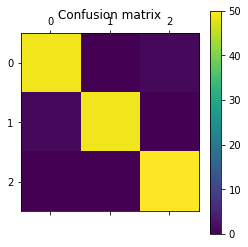

In [17]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## SVM

In [18]:
# Train the Linear SVM
from sklearn.svm import LinearSVC

clf = LinearSVC(max_iter=10000)

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['SVM'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


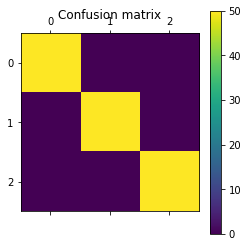

In [19]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## Random Forest:

In [20]:
# creating a random forest
clf =  RandomForestClassifier(n_estimators = 100, random_state=30)

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['random_forest'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.9933333333333333

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1       1.00      0.98      0.99        50
           2       1.00      1.00      1.00        50

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



[[50  0  0]
 [ 1 49  0]
 [ 0  0 50]]


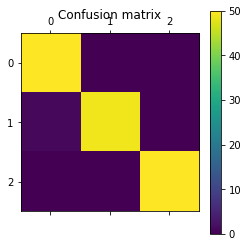

In [21]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## Decision Tree:

In [22]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['decision_tree'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.9733333333333334

              precision    recall  f1-score   support

           0       0.98      0.94      0.96        50
           1       0.96      1.00      0.98        50
           2       0.98      0.98      0.98        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



[[47  2  1]
 [ 0 50  0]
 [ 1  0 49]]


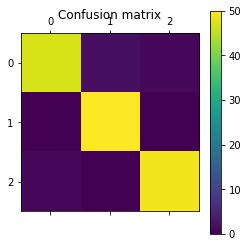

In [23]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

[Text(0.3958333333333333, 0.9166666666666666, 'X[2] <= 3.119\ngini = 0.667\nsamples = 600\nvalue = [200, 200, 200]'),
 Text(0.16666666666666666, 0.75, 'X[7] <= 5.296\ngini = 0.133\nsamples = 153\nvalue = [142, 11, 0]'),
 Text(0.08333333333333333, 0.5833333333333334, 'X[34] <= 509.217\ngini = 0.041\nsamples = 142\nvalue = [139, 3, 0]'),
 Text(0.041666666666666664, 0.4166666666666667, 'gini = 0.0\nsamples = 2\nvalue = [0, 2, 0]'),
 Text(0.125, 0.4166666666666667, 'X[12] <= 4.305\ngini = 0.014\nsamples = 140\nvalue = [139, 1, 0]'),
 Text(0.08333333333333333, 0.25, 'gini = 0.0\nsamples = 131\nvalue = [131, 0, 0]'),
 Text(0.16666666666666666, 0.25, 'X[31] <= 0.925\ngini = 0.198\nsamples = 9\nvalue = [8, 1, 0]'),
 Text(0.125, 0.08333333333333333, 'gini = 0.0\nsamples = 8\nvalue = [8, 0, 0]'),
 Text(0.20833333333333334, 0.08333333333333333, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.25, 0.5833333333333334, 'X[28] <= 0.616\ngini = 0.397\nsamples = 11\nvalue = [3, 8, 0]'),
 Text(0.2

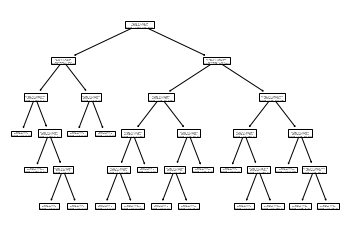

In [24]:
# plot tree
from sklearn import tree

tree.plot_tree(clf)

## AdaBoost Classifier:

In [25]:
# Create Adaboostclassifier
clf = AdaBoostClassifier(n_estimators=42)

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['ada_boost'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.74

              precision    recall  f1-score   support

           0       0.86      0.72      0.78        50
           1       0.64      0.50      0.56        50
           2       0.72      1.00      0.84        50

    accuracy                           0.74       150
   macro avg       0.74      0.74      0.73       150
weighted avg       0.74      0.74      0.73       150



[[36 14  0]
 [ 6 25 19]
 [ 0  0 50]]


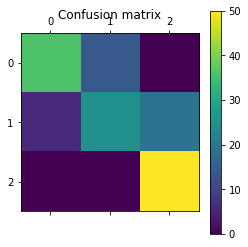

In [26]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## XG Boost Classifier:

In [27]:
# Create XG boost classifer object
xgb_clf = XGBClassifier()

xgb_clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = xgb_clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['xg_boost'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


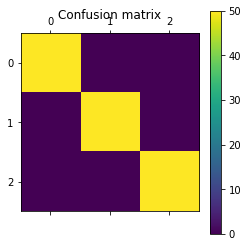

In [28]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## Gaussian Naive Bayes:

In [29]:
from sklearn.naive_bayes import GaussianNB

# Create Gaussian Naive Bayes Classifier
clf = GaussianNB()

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['gauss_NB'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 0.64

              precision    recall  f1-score   support

           0       0.61      0.74      0.67        50
           1       0.69      0.22      0.33        50
           2       0.66      0.96      0.78        50

    accuracy                           0.64       150
   macro avg       0.65      0.64      0.59       150
weighted avg       0.65      0.64      0.59       150



[[37  5  8]
 [22 11 17]
 [ 2  0 48]]


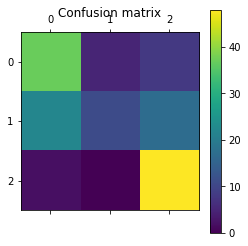

In [30]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

## Logistic Regression:

In [31]:
from sklearn.linear_model import LogisticRegression

# Create Logistic Regression Classifier
clf = LogisticRegression(solver='liblinear')

clf.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
results['log_regression'] = round(accuracy * 100, 2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy, end='\n\n')

print(classification_report(y_test, y_pred))

Accuracy: 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


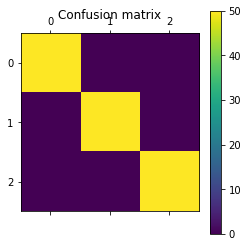

In [32]:
cm = confusion_matrix(y_test, y_pred)
print (cm)

showconfusionmatrix(cm)

# Plotting the results:

<BarContainer object of 8 artists>

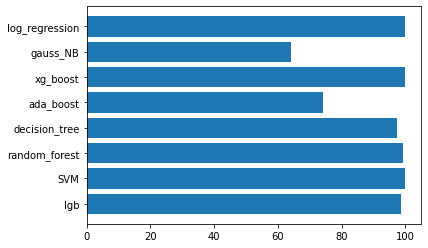

In [33]:
# horizontal bar plot
plt.barh(list(results.keys()), results.values())

In [34]:
results

{'SVM': 100.0,
 'ada_boost': 74.0,
 'decision_tree': 97.33,
 'gauss_NB': 64.0,
 'lgb': 98.67,
 'log_regression': 100.0,
 'random_forest': 99.33,
 'xg_boost': 100.0}

# Feature Analysis

In [37]:
#pip install eli5
from eli5 import show_weights, show_prediction
from eli5.sklearn import PermutationImportance

import pandas as pd

In [43]:
feature_names = []
# producing the name of each feature
# Looking a small numbers because we want to look at the nearest neighbors (Ex: Kernel Size 3: Dist of 3 of Pixels)
for size in [1, 3, 5]:
    for angle in [0, 45, 90, 135]:
        feature_names.append(f'energy_{size}_{angle}')
        feature_names.append(f'correlation_{size}_{angle}')
        feature_names.append(f'dissimilarity_{size}_{angle}')
        feature_names.append(f'homogeneity_{size}_{angle}')
        feature_names.append(f'contrast_{size}_{angle}')        

for feature in feature_names:
  print(feature)

energy_1_0
correlation_1_0
dissimilarity_1_0
homogeneity_1_0
contrast_1_0
energy_1_45
correlation_1_45
dissimilarity_1_45
homogeneity_1_45
contrast_1_45
energy_1_90
correlation_1_90
dissimilarity_1_90
homogeneity_1_90
contrast_1_90
energy_1_135
correlation_1_135
dissimilarity_1_135
homogeneity_1_135
contrast_1_135
energy_3_0
correlation_3_0
dissimilarity_3_0
homogeneity_3_0
contrast_3_0
energy_3_45
correlation_3_45
dissimilarity_3_45
homogeneity_3_45
contrast_3_45
energy_3_90
correlation_3_90
dissimilarity_3_90
homogeneity_3_90
contrast_3_90
energy_3_135
correlation_3_135
dissimilarity_3_135
homogeneity_3_135
contrast_3_135
energy_5_0
correlation_5_0
dissimilarity_5_0
homogeneity_5_0
contrast_5_0
energy_5_45
correlation_5_45
dissimilarity_5_45
homogeneity_5_45
contrast_5_45
energy_5_90
correlation_5_90
dissimilarity_5_90
homogeneity_5_90
contrast_5_90
energy_5_135
correlation_5_135
dissimilarity_5_135
homogeneity_5_135
contrast_5_135


## Gini Importance:

Text(0.5, 1.0, 'Feature Importances')

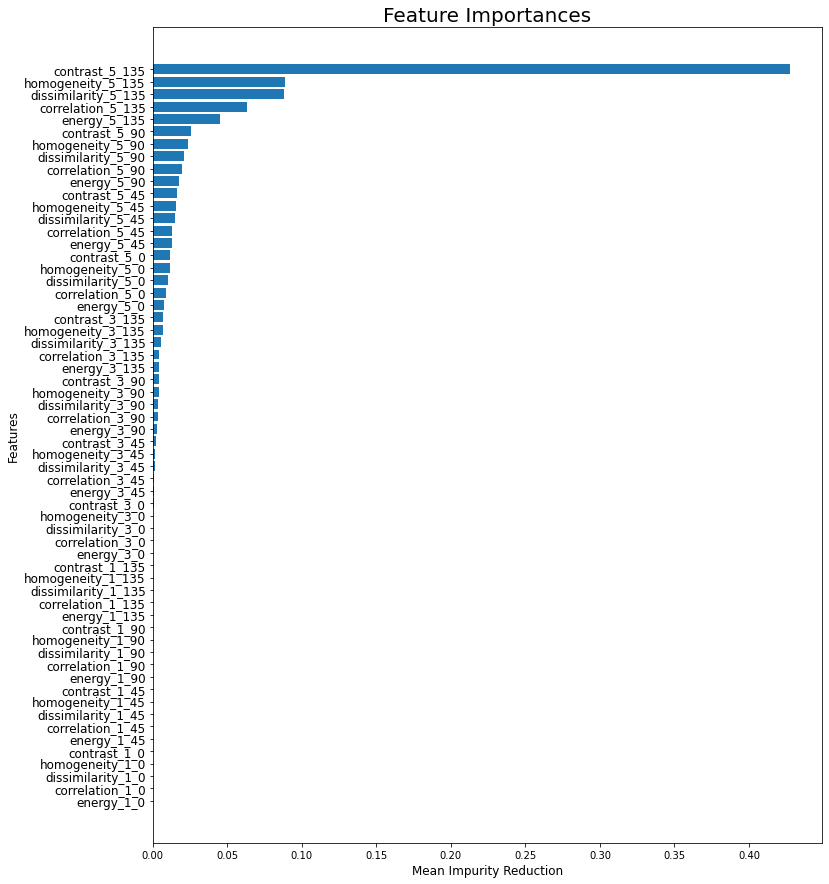

In [39]:
# applying on xgb
tree_feature =  pd.Series(xgb_clf.feature_importances_, feature_names).sort_values(ascending = True)
plt.figure(figsize=(12, 15))
plt.barh(feature_names, tree_feature)
plt.xlabel('Mean Impurity Reduction', fontsize = 12)
plt.ylabel('Features', fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Feature Importances', fontsize = 20)
# you need to remember that xgboost relies on the bootstrapping process for creating the model. 
# Which means, how important the feature is could happen because of the randomised process

## Permutation importance:
#### The idea behind permutation importance is how the scoring (accuracy, precision, recall, etc.) shift with the feature existence or no

In [40]:
# applying on xgb
# Permutation Importance
perm = PermutationImportance(xgb_clf, scoring = 'accuracy' ,random_state=101).fit(x_test, y_test)
show_weights(perm, feature_names = feature_names)
# The higher the position, the more critical the features are affecting the scoring.

Weight,Feature
0.0267 ± 0.0146,dissimilarity_1_45
0.0267 ± 0.0146,correlation_1_0
0.0173 ± 0.0065,contrast_5_90
0.0147 ± 0.0100,contrast_3_90
0.0147 ± 0.0100,contrast_5_0
0.0053 ± 0.0053,correlation_3_90
0.0040 ± 0.0065,homogeneity_1_0
0.0040 ± 0.0065,contrast_1_0
0.0040 ± 0.0065,dissimilarity_5_0
0.0013 ± 0.0053,correlation_1_90


## Tree Feature Importance :

In [41]:
# applying on logistic reg
show_weights(clf, feature_names = feature_names)

## Prediction Example:

In [42]:
show_prediction(clf, x_test[10], show_feature_values=True)